In [1]:
pip install catboost

# Specialist Weather Prediction Pipeline

## Overview
This notebook implements and compares different base learners for 3 prediction tasks: **Cold**, **Storm**, and **Heat** severe weather events. We use a **Binary Relevance** approach (one specialist model per event type) with **Expanding Window Temporal Cross-Validation**.


## Strategy: Specialist Models
Instead of one model for all events, we train independent "specialist" models:

| Model | Target | Why Separate? |
|-------|--------|---------------|
| Model A | Cold | Driven by temperature drops, pressure systems |
| Model B | Storm | Driven by pressure instability, wind patterns |
| Model C | Heat | Driven by extreme high temperatures, radiation |

## Validation: Expanding Window Temporal CV (4 Folds)

Tests: **"Does the model generalize to future time periods?"**

| Fold | Training Period | Validation Period |
|------|-----------------|-------------------|
| 1 | Jan 2019 – Dec 2019 | Jan – Mar 2020 |
| 2 | Jan 2019 – Mar 2020 | Apr – Jun 2020 |
| 3 | Jan 2019 – Jun 2020 | Jul – Sep 2020 |
| 4 | Jan 2019 – Sep 2020 | Oct – Dec 2020 |

This prevents **temporal leakage** and simulates real deployment (train on past, predict future).

## Models & Imbalance Handling

| Model | Imbalance Mechanism |
|-------|---------------------|
| Logistic Regression | `class_weight='balanced'` |
| Random Forest | `class_weight='balanced_subsample'` |
| XGBoost | `scale_pos_weight` (Neg/Pos ratio) + `min_child_weight=10` |
| CatBoost | `auto_class_weights='Balanced'` |
| LSTM | `class_weight` dict (Neg/Pos ratio) |

## KPIs
- **ROC-AUC**: Ranking ability (1.0 = perfect, 0.5 = random)
- **Brier Score (MSE)**: Probability calibration (0.0 = perfect)


Our analysis demonstrates that tree-based models offer the optimal balance between computational efficiency and predictive performance. Consequently, we have selected XGBoost as our primary model for this project, as it delivers high accuracy while maintaining significantly faster training times compared to other ensembles.

## Section 1: Setup and Imports

We need the following packages:
- **pandas/numpy**: Data manipulation
- **scikit-learn**: Logistic Regression, Random Forest, preprocessing, metrics
- **xgboost**: Gradient boosting classifier
- **catboost**: Ordered gradient boosting with best probability calibration
- **tensorflow/keras**: LSTM (Long Short-Term Memory) deep learning model
- **matplotlib/seaborn**: Visualization
- **tqdm**: Progress bars for long training loops

In [2]:
# Core data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, log_loss,
    average_precision_score, precision_recall_curve,
    f1_score, precision_score, recall_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm import tqdm

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("All packages imported successfully!")

All packages imported successfully!


## Section 2: Load Data

We load the pre-processed dataset that contains:
- **Daily weather observations** for multiple cities/states
- **Weather features**: temperature, humidity, pressure, wind, precipitation, cloud cover
- **Event labels**: Which severe weather events occurred on each day

The data covers 2019-2020, which gives us enough temporal range for expanding window validation.

In [3]:
# Load the dataset
DATA_PATH = "final_processed_weather_data.csv"
df = pd.read_csv(DATA_PATH)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display basic info
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Unique States: {df['State'].nunique()}")
print(f"Unique Cities: {df['City'].nunique()}")
print(f"\nStates in dataset: {sorted(df['State'].unique())}")

# Preview the data
df.head()

Dataset Shape: 252,616 rows × 51 columns
Date Range: 2019-01-04 to 2020-12-31
Unique States: 47
Unique Cities: 347

States in dataset: ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


,Date,City,State,Latitude,Longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,...,temperature_2m_mean_rolling7_std,pressure_msl_mean_lag1,pressure_msl_mean_lag3,pressure_msl_mean_rolling7_mean,pressure_msl_mean_rolling7_std,relative_humidity_2m_mean_lag1,relative_humidity_2m_mean_lag3,relative_humidity_2m_mean_rolling7_mean,relative_humidity_2m_mean_rolling7_std,has_heat
0,2019-01-04,Aberdeen,MS,33.8738,-88.4897,12.1,7.2,9.4,16.2,16.2,...,1.707581,1018.4,1019.7,1017.575,5.987417,95.0,90.0,92.250000,2.061553,0
1,2019-01-05,Aberdeen,MS,33.8738,-88.4897,14.9,3.7,7.9,0.0,0.0,...,1.722498,1009.1,1023.1,1017.560,5.185364,92.0,92.0,89.600000,6.188699,0
2,2019-01-06,Aberdeen,MS,33.8738,-88.4897,16.5,2.5,8.5,0.0,0.0,...,1.591750,1017.5,1018.4,1018.350,5.025435,79.0,95.0,88.166667,6.554896,0
3,2019-01-07,Aberdeen,MS,33.8738,-88.4897,18.4,6.9,11.4,0.0,0.0,...,1.652703,1022.3,1009.1,1018.700,4.680100,81.0,92.0,86.714286,7.111359,0
4,2019-01-08,Aberdeen,MS,33.8738,-88.4897,19.6,13.6,16.0,1.4,1.4,...,2.815265,1020.8,1017.5,1018.700,4.680100,78.0,79.0,85.142857,7.470577,0


## Section 3: Create Binary Target Variables

The `Event_Types` column contains comma-separated event types (e.g., "Cold", "Cold, Storm").
We need to parse this into **separate binary columns** for each specialist model:

- `has_cold`: 1 if Cold event occurred, 0 otherwise
- `has_storm`: 1 if Storm event occurred, 0 otherwise
- `has_heat`: 1 if extreme Heat event occurred, 0 otherwise (pre-computed in dataset using dual-threshold logic — see Overview)

### Why Binary Relevance?
This approach treats each label independently. While it ignores potential correlations between events (e.g., storms often bring cold), it:
1. Allows specialized tuning per event type
2. Handles different imbalance ratios independently
3. Is simpler to interpret and debug

In [4]:
# Create binary target columns by checking if event type is in the Event_Types string
def create_binary_target(event_types_col, target_event):
    """
    Parse Event_Types column and create binary indicator for a specific event.

    Args:
        event_types_col: Series containing event type strings (e.g., "Cold", "Cold, Storm")
        target_event: The event to look for (e.g., "Cold")

    Returns:
        Binary series (1 if event present, 0 otherwise)
    """
    return event_types_col.fillna('').str.contains(target_event, case=False).astype(int)

# Create binary targets for Cold and Storm from Event_Types
df['has_cold'] = create_binary_target(df['Event_Types'], 'Cold')
df['has_storm'] = create_binary_target(df['Event_Types'], 'Storm')

# has_heat is already pre-computed in the dataset using a dual-threshold approach:
#   Absolute:  temperature_2m_max >= 35°C  (universally extreme)
#   Relative:  temperature_2m_max > city 95th-percentile AND > 28°C (locally unusual)
# A day is has_heat=1 if EITHER condition is met.
assert 'has_heat' in df.columns, "has_heat column not found in dataset!"

# Display class distribution for each target
print("=" * 60)
print("CLASS DISTRIBUTION (Imbalance Analysis)")
print("=" * 60)

targets = ['has_cold', 'has_storm', 'has_heat']
for target in targets:
    pos_count = df[target].sum()
    neg_count = len(df) - pos_count
    pos_pct = 100 * pos_count / len(df)
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else float('inf')

    print(f"\n{target.upper().replace('HAS_', '')}:")
    print(f"  Positive (Event):     {pos_count:>6,} ({pos_pct:>5.2f}%)")
    print(f"  Negative (No Event):  {neg_count:>6,} ({100-pos_pct:>5.2f}%)")
    print(f"  Imbalance Ratio:      1:{imbalance_ratio:.1f}")

CLASS DISTRIBUTION (Imbalance Analysis)

COLD:
  Positive (Event):      8,069 ( 3.19%)
  Negative (No Event):  244,547 (96.81%)
  Imbalance Ratio:      1:30.3

STORM:
  Positive (Event):      1,901 ( 0.75%)
  Negative (No Event):  250,715 (99.25%)
  Imbalance Ratio:      1:131.9

HEAT:
  Positive (Event):     18,508 ( 7.33%)
  Negative (No Event):  234,108 (92.67%)
  Imbalance Ratio:      1:12.6


## Section 4: Feature Engineering (Advanced)

We engineer features at multiple levels to capture different aspects of weather patterns:

### 4.1 Base Features
Raw weather measurements from the dataset (temperature, humidity, pressure, wind, etc.)

### 4.2 Temporal Features
- **Month, Day of Year**: Capture seasonality (for example - storms more common in spring/summer)
- **Season**: Categorical encoding of meteorological seasons

### 4.3 Derived Features
- **Temperature Range**: Large daily swings may indicate instability
- **Pressure Range**: Rapid pressure changes often precede storms
- **Humidity Range**: Variability in moisture content

### 4.4 Lag Features
Previous day's values help capture **trends**. If pressure dropped yesterday, it might continue dropping.

### 4.5 Rolling Statistics
7-day rolling mean and standard deviation capture **recent weather patterns** and variability.

**Important**: Lag and rolling features must be computed **per location** (City) to avoid data leakage across different places.

In [5]:
# Define base feature columns (raw weather measurements)
BASE_FEATURES = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'relative_humidity_2m_max', 'relative_humidity_2m_min', 'relative_humidity_2m_mean',
    'pressure_msl_max', 'pressure_msl_min', 'pressure_msl_mean',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
    'cloud_cover_mean', 'shortwave_radiation_sum'
]

# Verify all base features exist in the dataset
missing_features = [f for f in BASE_FEATURES if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    BASE_FEATURES = [f for f in BASE_FEATURES if f in df.columns]

print(f"Using {len(BASE_FEATURES)} base features")
print(BASE_FEATURES)

Using 18 base features
['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m_max', 'relative_humidity_2m_min', 'relative_humidity_2m_mean', 'pressure_msl_max', 'pressure_msl_min', 'pressure_msl_mean', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'cloud_cover_mean', 'shortwave_radiation_sum']


In [6]:
# ============================================================
# 4.2 TEMPORAL FEATURES
# ============================================================
# These capture seasonality - weather events have strong seasonal patterns

# Month (1-12): Captures monthly patterns
df['month'] = df['Date'].dt.month

# Day of year (1-365): Captures finer seasonal patterns
df['day_of_year'] = df['Date'].dt.dayofyear

# Season: Meteorological seasons
# Winter: Dec, Jan, Feb (12, 1, 2)
# Spring: Mar, Apr, May (3, 4, 5)
# Summer: Jun, Jul, Aug (6, 7, 8)
# Fall: Sep, Oct, Nov (9, 10, 11)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(get_season)

TEMPORAL_FEATURES = ['month', 'day_of_year', 'season']
print(f"Created {len(TEMPORAL_FEATURES)} temporal features: {TEMPORAL_FEATURES}")

Created 3 temporal features: ['month', 'day_of_year', 'season']


In [7]:
# ============================================================
# 4.3 DERIVED FEATURES
# ============================================================
# These capture daily variability which can indicate weather instability

# Temperature range: Large swings may indicate frontal passages
df['temp_range'] = df['temperature_2m_max'] - df['temperature_2m_min']

# Pressure range: Rapid changes often precede severe weather
df['pressure_range'] = df['pressure_msl_max'] - df['pressure_msl_min']

# Humidity range: Variability in moisture
df['humidity_range'] = df['relative_humidity_2m_max'] - df['relative_humidity_2m_min']

DERIVED_FEATURES = ['temp_range', 'pressure_range', 'humidity_range']
print(f"Created {len(DERIVED_FEATURES)} derived features: {DERIVED_FEATURES}")

Created 3 derived features: ['temp_range', 'pressure_range', 'humidity_range']


In [8]:
# ============================================================
# 4.4 & 4.5 LAG AND ROLLING FEATURES
# ============================================================
# CRITICAL: Must be computed per City to avoid spatial data leakage!
# We sort by Date within each City before computing lags/rolling.

# Features to create lags and rolling stats for
KEY_FEATURES = ['temperature_2m_mean', 'pressure_msl_mean', 'relative_humidity_2m_mean']

# Sort data by City and Date (required for proper lag/rolling computation)
df = df.sort_values(['City', 'Date']).reset_index(drop=True)

LAG_FEATURES = []
ROLLING_FEATURES = []

print("Computing lag and rolling features per city...")

for feature in tqdm(KEY_FEATURES, desc="Processing features"):
    # --- LAG FEATURES ---
    # Lag 1: Previous day's value
    lag1_name = f'{feature}_lag1'
    df[lag1_name] = df.groupby('City')[feature].shift(1)
    LAG_FEATURES.append(lag1_name)

    # Lag 3: Value from 3 days ago (captures short-term trends)
    lag3_name = f'{feature}_lag3'
    df[lag3_name] = df.groupby('City')[feature].shift(3)
    LAG_FEATURES.append(lag3_name)

    # --- ROLLING FEATURES ---
    # 7-day rolling mean: Recent average conditions
    roll_mean_name = f'{feature}_rolling7_mean'
    df[roll_mean_name] = df.groupby('City')[feature].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    ROLLING_FEATURES.append(roll_mean_name)

    # 7-day rolling std: Recent variability
    roll_std_name = f'{feature}_rolling7_std'
    df[roll_std_name] = df.groupby('City')[feature].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    ROLLING_FEATURES.append(roll_std_name)

print(f"\nCreated {len(LAG_FEATURES)} lag features: {LAG_FEATURES}")
print(f"Created {len(ROLLING_FEATURES)} rolling features: {ROLLING_FEATURES}")

Computing lag and rolling features per city...


Processing features: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Created 6 lag features: ['temperature_2m_mean_lag1', 'temperature_2m_mean_lag3', 'pressure_msl_mean_lag1', 'pressure_msl_mean_lag3', 'relative_humidity_2m_mean_lag1', 'relative_humidity_2m_mean_lag3']
Created 6 rolling features: ['temperature_2m_mean_rolling7_mean', 'temperature_2m_mean_rolling7_std', 'pressure_msl_mean_rolling7_mean', 'pressure_msl_mean_rolling7_std', 'relative_humidity_2m_mean_rolling7_mean', 'relative_humidity_2m_mean_rolling7_std']


In [9]:
# ============================================================
# COMBINE ALL FEATURES AND HANDLE MISSING VALUES
# ============================================================

# Combine all feature lists
ALL_FEATURES = BASE_FEATURES + TEMPORAL_FEATURES + DERIVED_FEATURES + LAG_FEATURES + ROLLING_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  - Base features: {len(BASE_FEATURES)}")
print(f"  - Temporal features: {len(TEMPORAL_FEATURES)}")
print(f"  - Derived features: {len(DERIVED_FEATURES)}")
print(f"  - Lag features: {len(LAG_FEATURES)}")
print(f"  - Rolling features: {len(ROLLING_FEATURES)}")

# Check for missing values
rows_before = len(df)
missing_rows = df[ALL_FEATURES].isnull().any(axis=1).sum()
print(f"\nRows with missing values: {missing_rows:,} ({100*missing_rows/rows_before:.2f}%)")

# Why we DROP instead of impute:
# - Missing values only occur in first ~3 days per city (lag/rolling features)
# - These rows lack meaningful historical context anyway
# - Dropping is cleaner than imputing artificial values
# - Data loss is minimal (~3 days × n_cities)

df = df.dropna(subset=ALL_FEATURES).reset_index(drop=True)

rows_after = len(df)
print(f"Rows dropped: {rows_before - rows_after:,}")
print(f"Rows remaining: {rows_after:,} ({100*rows_after/rows_before:.2f}%)")

Total features: 36
  - Base features: 18
  - Temporal features: 3
  - Derived features: 3
  - Lag features: 6
  - Rolling features: 6

Rows with missing values: 1,041 (0.41%)
Rows dropped: 1,041
Rows remaining: 251,575 (99.59%)


## Section 5: Cross-Validation Framework

We implement **Expanding Window Temporal Cross-Validation** to test time-series generalization:

### Expanding Window (4 folds)
- **Goal**: Test if model generalizes to **future time periods**
- **Method**: Train on historical data, validate on future quarters with expanding training window
- **Why**: Weather prediction must work on future dates, not just historical ones

This prevents **temporal leakage** and answers: **"Will this model work on next quarter's data?"**

In [10]:
# ============================================================
# EXPANDING WINDOW TEMPORAL SPLITTER
# ============================================================
# Implements time-series cross-validation with expanding training window.
# Training window grows over time, validation is always the next quarter.

class ExpandingWindowSplit:
    """
    Temporal cross-validator using expanding training windows.

    This mimics real-world deployment: train on all historical data,
    predict future periods. The training set grows with each fold.
    """

    def __init__(self):
        # Define the temporal folds
        # Format: (train_end_date, val_start_date, val_end_date)
        self.folds = [
            ('2019-12-31', '2020-01-01', '2020-03-31'),  # Fold 1: Full 2019 → Q1 2020
            ('2020-03-31', '2020-04-01', '2020-06-30'),  # Fold 2: +Q1 2020 → Q2 2020
            ('2020-06-30', '2020-07-01', '2020-09-30'),  # Fold 3: +Q2 2020 → Q3 2020
            ('2020-09-30', '2020-10-01', '2020-12-31'),  # Fold 4: +Q3 2020 → Q4 2020
        ]
        # Training always starts from the beginning of the dataset
        self.train_start = '2019-01-01'

    def split(self, df, date_col='Date'):
        """
        Generate indices for expanding window splits.

        Args:
            df: DataFrame with data
            date_col: Name of the date column

        Yields:
            train_idx, val_idx: Arrays of indices
        """
        dates = pd.to_datetime(df[date_col])

        for train_end, val_start, val_end in self.folds:
            train_end = pd.to_datetime(train_end)
            val_start = pd.to_datetime(val_start)
            val_end = pd.to_datetime(val_end)

            # Training: all data from start up to train_end
            train_mask = (dates >= self.train_start) & (dates <= train_end)

            # Validation: data in the validation window
            val_mask = (dates >= val_start) & (dates <= val_end)

            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]

            # Only yield if both sets have data
            if len(train_idx) > 0 and len(val_idx) > 0:
                yield train_idx, val_idx

    def get_n_splits(self):
        return len(self.folds)

# Create the temporal CV splitter
temporal_cv = ExpandingWindowSplit()

print("Expanding Window Temporal CV Configuration:")
print(f"  Number of folds: {temporal_cv.get_n_splits()}")
print(f"\nFold details:")
for i, (train_end, val_start, val_end) in enumerate(temporal_cv.folds, 1):
    print(f"  Fold {i}: Train until {train_end} → Validate {val_start} to {val_end}")

Expanding Window Temporal CV Configuration:
  Number of folds: 4

Fold details:
  Fold 1: Train until 2019-12-31 → Validate 2020-01-01 to 2020-03-31
  Fold 2: Train until 2020-03-31 → Validate 2020-04-01 to 2020-06-30
  Fold 3: Train until 2020-06-30 → Validate 2020-07-01 to 2020-09-30
  Fold 4: Train until 2020-09-30 → Validate 2020-10-01 to 2020-12-31


## Section 6: Model Definitions

We compare **5 model architectures**, each tuned for this specific task:
250k samples, 36 features, 3–10% positive rate (severe imbalance), temporal generalization.

| Model | Type | Imbalance Handling | Key Tuning |
|-------|------|--------------------|------------|
| **Logistic Regression** | Linear baseline | `class_weight='balanced'` | `C=0.1` (stronger regularization for large N), `solver='saga'` |
| **Random Forest** | Bagging | `class_weight='balanced_subsample'` | `n_estimators=200`, `max_depth=10`, `min_samples_leaf=20`, `max_features='sqrt'` |
| **XGBoost** | Boosting | `scale_pos_weight` | `n_estimators=500`, `lr=0.03`, stochastic subsampling, `min_child_weight=10`, L1+L2 regularization |
| **CatBoost** | Ordered boosting | `auto_class_weights='Balanced'` | `iterations=200`, `lr=0.08`, `l2_leaf_reg=5`, `border_count=64` |
| **LSTM** | Deep Learning (RNN) | `class_weight` dict | `batch_size=512`, `epochs=30` + EarlyStopping |

### Why These Models?
- **Logistic Regression**: Interpretable linear baseline. Tests whether simple linear separation of weather features is sufficient.
- **Random Forest**: Bagging approach — averages many independent trees. `min_samples_leaf=20` is critical here: with ~4k positives per fold, it stops individual trees from memorizing rare minority-class patterns.
- **XGBoost**: Sequential gradient boosting with the most complete regularization suite. The combination of `min_child_weight=10`, stochastic subsampling, and L1+L2 gives it the best control over overfitting on imbalanced temporal data.
- **CatBoost**: Ordered boosting prevents target leakage during training. Symmetric (oblivious) trees at `depth=6` give 64 leaves — well-matched to our 36 features.
- **LSTM**: Recurrent deep learning baseline. Although lag/rolling features are already pre-computed, the LSTM can learn additional non-linear temporal dependencies.


In [11]:
# ============================================================
# LSTM WRAPPER (sklearn-compatible interface)
# ============================================================
# Wraps a Keras LSTM model so it can be used in the same
# training loop as the sklearn / boosting models.

class LSTMClassifier:
    """
    LSTM classifier with sklearn-like fit / predict_proba API.

    Each sample is reshaped into a single-step sequence
    (timesteps=1, features=n_features). This lets the LSTM
    act as a non-linear classifier while keeping the same
    cross-validation framework as the other models.
    """

    def __init__(self, n_features, n_positive=1, n_negative=1,
                 epochs=30, batch_size=256, random_state=42):
        self.n_features = n_features
        self.epochs = epochs
        # Smaller batch → more gradient updates per epoch, better signal
        # on the rare positive class without needing oversampling.
        self.batch_size = batch_size
        self.random_state = random_state
        self.n_positive = n_positive
        self.n_negative = n_negative
        self.model = None

    def _build_model(self):
        tf.random.set_seed(self.random_state)
        model = Sequential([
            LSTM(64, input_shape=(1, self.n_features), return_sequences=True),
            Dropout(0.3),
            LSTM(32),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def fit(self, X, y, **kwargs):
        np.random.seed(self.random_state)
        tf.random.set_seed(self.random_state)

        # Reshape: (samples, 1 timestep, features)
        X_seq = X.reshape(X.shape[0], 1, X.shape[1])

        # Class weights for imbalance handling
        class_weight = {
            0: 1.0,
            1: self.n_negative / self.n_positive if self.n_positive > 0 else 1.0
        }

        self.model = self._build_model()
        self.model.fit(
            X_seq, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            class_weight=class_weight,
            verbose=0,
            callbacks=[EarlyStopping(patience=5,
                                     restore_best_weights=True,
                                     monitor='val_loss')],
            validation_split=0.1
        )
        return self

    def predict_proba(self, X):
        X_seq = X.reshape(X.shape[0], 1, X.shape[1])
        pos_proba = self.model.predict(X_seq, verbose=0).flatten()
        return np.column_stack([1 - pos_proba, pos_proba])


# ============================================================
# MODEL FACTORY
# ============================================================
# All models are tuned for the task specifics:
#   - ~250k samples, 36 features
#   - Severe class imbalance (3–10% positive rate)
#   - Temporal generalization (train on past, predict future)
#
# Tuning philosophy per model is documented inline.

def create_models(n_positive, n_negative, n_features=None):
    """
    Create dictionary of models with imbalance-aware configurations.

    Args:
        n_positive: Number of positive samples in training set
        n_negative: Number of negative samples in training set
        n_features: Number of input features (needed for LSTM)

    Returns:
        Dictionary of model name → model instance
    """
    scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

    models = {

        # ── Logistic Regression ────────────────────────────────────────────
        # Linear baseline. With 250k samples the default C=1 is too loose
        # (under-regularized), so we tighten to C=0.1.
        # 'saga' solver scales much better than 'lbfgs' on large datasets
        # and supports L1/L2 penalties without changing the API.
        'Logistic_Regression': LogisticRegression(
            C=0.1,                    # Stronger L2 regularization for large N
            class_weight='balanced',
            max_iter=2000,            # Extra budget for convergence at large N
            solver='saga',            # Faster than lbfgs for >50k samples
            random_state=RANDOM_STATE
        ),

        # ── Random Forest ──────────────────────────────────────────────────
        # Bagging baseline. Key choices for this task:
        #   n_estimators=200: enough to stabilize OOB error; beyond 300
        #     the gain is marginal for our feature set.
        #   max_depth=10: weather interactions exist but aren't very deep;
        #     unlimited depth would just memorize the majority class.
        #   min_samples_leaf=20: with ~4k positives in the first training
        #     fold, this prevents leaf nodes that represent a handful of
        #     rare events (avoids overfitting to noise in the minority class).
        #   max_features='sqrt': standard for classification (≈6 features
        #     per split from 36 total), injects diversity between trees.
        'Random_Forest': RandomForestClassifier(
            n_estimators=200,
            class_weight='balanced_subsample',
            max_depth=10,
            min_samples_leaf=20,
            max_features='sqrt',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),

        # ── XGBoost ────────────────────────────────────────────────────────
        # Fully tuned gradient booster. Key choices:
        #   n_estimators=500 + learning_rate=0.03: more rounds with smaller
        #     steps is the classic bias-variance sweet spot for boosting.
        #   max_depth=5: shallower individual trees prevent any single tree
        #     from memorizing majority-class patterns; 500 trees compensate.
        #   subsample=0.8 + colsample_bytree=0.8: stochastic boosting reduces
        #     variance and prevents co-adaptation between features (similar to
        #     Random Forest's max_features).
        #   min_child_weight=10: with ~3% positive rate, each tree split must
        #     cover ≥10 weighted samples → stops splitting on statistically
        #     weak positive-class nodes (most important regularizer here).
        #   gamma=0.1: minimum loss reduction required to make a split;
        #     prunes leaves that add no real predictive value.
        #   reg_alpha=0.1 (L1): sparse feature selection, good for the
        #     correlated lag/rolling features in our feature set.
        #   reg_lambda=2.0 (L2): shrinks leaf weights uniformly.
        'XGBoost': XGBClassifier(
            n_estimators=500,
            scale_pos_weight=scale_pos_weight,
            max_depth=5,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=10,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=2.0,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        ),

        # ── CatBoost ───────────────────────────────────────────────────────
        # Ordered gradient booster. Key choices:
        #   iterations=200 + learning_rate=0.08: slightly lower LR than
        #     default (0.1) to improve generalization; 200 iterations is
        #     a meaningful improvement over 100 without excessive runtime.
        #   depth=6: CatBoost uses symmetric (oblivious) trees — depth=6
        #     gives 64 leaves per tree which is well-suited to our feature
        #     count; going deeper increases memory quadratically.
        #   l2_leaf_reg=5: raised from default 3 for better regularization
        #     on the imbalanced targets.
        #   border_count=64: histogram bin count for numerical features;
        #     default 254 is overkill for 36 features, 64 is faster.
        'CatBoost': CatBoostClassifier(
            iterations=200,
            auto_class_weights='Balanced',
            depth=6,
            learning_rate=0.08,
            l2_leaf_reg=5,
            border_count=64,
            random_state=RANDOM_STATE,
            verbose=0
        ),

        # ── LSTM ───────────────────────────────────────────────────────────
        # Deep learning baseline. Key choices:
        #   batch_size=512:default;
        #     per epoch gives better learning signal on the rare positive
        #     class without oversampling.
        #   epochs=30 + EarlyStopping(patience=5): enough ceiling for the
        #     model to converge; early stopping on val_loss prevents
        #     overfitting to the majority class.
        'LSTM': LSTMClassifier(
            n_features=n_features if n_features else 36,
            n_positive=n_positive,
            n_negative=n_negative,
            epochs=30,
            batch_size=512,
            random_state=RANDOM_STATE
        )
    }

    return models


print("Model factory defined!")
print("\nModel configurations summary:")
print(f"  Logistic Regression : C=0.1, solver=saga, max_iter=2000")
print(f"  Random Forest       : n_estimators=200, max_depth=10, min_samples_leaf=20, max_features=sqrt")
print(f"  XGBoost             : n_estimators=500, lr=0.03, max_depth=5, subsample=0.8,")
print(f"                        colsample=0.8, min_child_weight=10, gamma=0.1, α=0.1, λ=2.0")
print(f"  CatBoost            : iterations=200, lr=0.08, depth=6, l2_leaf_reg=5, border_count=64")
print(f"  LSTM                : epochs=30 (EarlyStopping p=5), batch_size=256")


Model factory defined!

Model configurations summary:
  Logistic Regression : C=0.1, solver=saga, max_iter=2000
  Random Forest       : n_estimators=200, max_depth=10, min_samples_leaf=20, max_features=sqrt
  XGBoost             : n_estimators=500, lr=0.03, max_depth=5, subsample=0.8,
                        colsample=0.8, min_child_weight=10, gamma=0.1, α=0.1, λ=2.0
  CatBoost            : iterations=200, lr=0.08, depth=6, l2_leaf_reg=5, border_count=64
  LSTM                : epochs=30 (EarlyStopping p=5), batch_size=256


## Section 7: Main Training Loop

In [12]:
# ============================================================
# MAIN TRAINING LOOP - TEMPORAL CROSS-VALIDATION
# ============================================================

results = []

TARGET_COLS = ['has_cold', 'has_storm', 'has_heat']
input_dim = len(ALL_FEATURES)
last_fold_num = temporal_cv.get_n_splits()

print("=" * 70)
print("STARTING TEMPORAL CROSS-VALIDATION")
print("=" * 70)
print(f"Features: {input_dim}")
print(f"Targets: {TARGET_COLS}")
print(f"Total samples: {len(df):,}")
print(f"Temporal folds: {temporal_cv.get_n_splits()}")
print("=" * 70)

for target_col in TARGET_COLS:
    target_name = target_col.replace('has_', '').upper()
    print(f"\n{'='*70}")
    print(f"TRAINING SPECIALIST MODEL: {target_name}")
    print(f"{'='*70}")

    for fold_idx, (train_idx, val_idx) in enumerate(temporal_cv.split(df)):
        train_end, val_start, val_end = temporal_cv.folds[fold_idx]

        print(f"\n  Fold {fold_idx + 1}/{temporal_cv.get_n_splits()}")
        print(f"    Train: until {train_end}, {len(train_idx):,} samples")
        print(f"    Validate: {val_start} to {val_end}, {len(val_idx):,} samples")

        X_train = df.iloc[train_idx][ALL_FEATURES].values
        y_train = df.iloc[train_idx][target_col].values
        X_val   = df.iloc[val_idx][ALL_FEATURES].values
        y_val   = df.iloc[val_idx][target_col].values

        if y_train.sum() < 5 or y_val.sum() < 2:
            print(f"    ⚠ Skipped: insufficient positive samples")
            continue

        # Fit scaler on train only — prevents leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)

        n_positive = int(y_train.sum())
        n_negative = len(y_train) - n_positive

        models = create_models(n_positive, n_negative, n_features=input_dim)

        for model_name, model in models.items():
            try:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict_proba(X_val_scaled)[:, 1]

                # ── Threshold-free metrics ─────────────────────────────────
                roc_auc  = roc_auc_score(y_val, y_pred)
                pr_auc   = average_precision_score(y_val, y_pred)
                brier    = brier_score_loss(y_val, y_pred)
                logloss  = log_loss(y_val, y_pred)

                # ── Threshold-based metrics (optimal F1 threshold) ─────────
                # Find threshold that maximises F1 on the validation fold.
                # Using precision_recall_curve avoids iterating over all
                # possible thresholds explicitly.
                precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
                # precisions/recalls have one extra element (at threshold=1),
                # so we align with [:-1]
                f1_scores_curve = (
                    2 * precisions[:-1] * recalls[:-1]
                    / (precisions[:-1] + recalls[:-1] + 1e-8)
                )
                best_idx       = np.argmax(f1_scores_curve)
                best_threshold = thresholds[best_idx]
                y_pred_binary  = (y_pred >= best_threshold).astype(int)

                f1        = f1_score(y_val, y_pred_binary, zero_division=0)
                precision = precision_score(y_val, y_pred_binary, zero_division=0)
                recall    = recall_score(y_val, y_pred_binary, zero_division=0)

                results.append({
                    'target':          target_name,
                    'model':           model_name,
                    'fold':            fold_idx + 1,
                    'val_period':      f"{val_start} to {val_end}",
                    # threshold-free
                    'roc_auc':         roc_auc,
                    'pr_auc':          pr_auc,
                    'brier_score':     brier,
                    'log_loss':        logloss,
                    # threshold-based (at optimal F1 cut)
                    'f1':              f1,
                    'precision':       precision,
                    'recall':          recall,
                    'best_threshold':  best_threshold,
                    # metadata
                    'n_train':         len(y_train),
                    'n_val':           len(y_val),
                    'pos_rate_train':  y_train.mean(),
                    'pos_rate_val':    y_val.mean(),
                })

            except Exception as e:
                print(f"      ⚠ {model_name}: {str(e)[:60]}")

        print(f"    ✓ Complete")

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print(f"Total results recorded: {len(results)}")
print("=" * 70)


STARTING TEMPORAL CROSS-VALIDATION
Features: 36
Targets: ['has_cold', 'has_storm', 'has_heat']
Total samples: 251,575
Temporal folds: 4

TRAINING SPECIALIST MODEL: COLD

  Fold 1/4
    Train: until 2019-12-31, 124,573 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples
    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 156,150 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples
    ✓ Complete

  Fold 3/4
    Train: until 2020-06-30, 187,727 samples
    Validate: 2020-07-01 to 2020-09-30, 31,924 samples
    ✓ Complete

  Fold 4/4
    Train: until 2020-09-30, 219,651 samples
    Validate: 2020-10-01 to 2020-12-31, 31,924 samples
    ✓ Complete

TRAINING SPECIALIST MODEL: STORM

  Fold 1/4
    Train: until 2019-12-31, 124,573 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples
    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 156,150 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples
    ✓ Complete

  Fold 3/4
    Train: until 2020-0

## Section 8: Results Aggregation

We aggregate all 7 metrics across the 4 temporal folds (mean ± std).

**Threshold-free** (evaluate the full probability ranking):
- **ROC-AUC** — ranking ability across all thresholds (optimistic on imbalanced data)
- **PR-AUC** (Average Precision) — precision-recall tradeoff; much more informative at 3–10% positive rate
- **Brier Score** — mean squared error of probabilities; lower = better calibration
- **Log Loss** — penalises confident wrong predictions more than Brier; lower = better

**Threshold-based** (at the threshold that maximises F1 on each validation fold):
- **F1** — harmonic mean of precision and recall
- **Precision** — of all predicted positives, how many are actually positive
- **Recall** — of all actual positives, how many did we catch


In [13]:
# ============================================================
# CONVERT RESULTS TO DATAFRAME
# ============================================================

results_df = pd.DataFrame(results)

print(f"Results shape: {results_df.shape}")
print(f"Metrics recorded: roc_auc, pr_auc, brier_score, log_loss, f1, precision, recall")
print(f"Results per target: {results_df.groupby('target').size().to_dict()}")


Results shape: (60, 16)
Metrics recorded: roc_auc, pr_auc, brier_score, log_loss, f1, precision, recall
Results per target: {'COLD': 20, 'HEAT': 20, 'STORM': 20}


In [20]:
# ============================================================
# AGGREGATE: MEAN ± STD ACROSS FOLDS
# ============================================================

METRICS = ['roc_auc', 'pr_auc', 'brier_score', 'log_loss', 'f1', 'precision', 'recall']

agg_dict = {m: ['mean', 'std'] for m in METRICS}
summary_df = (
    results_df.groupby(['target', 'model'])
    .agg(agg_dict)
    .round(4)
)
summary_df.columns = ['_'.join(col) for col in summary_df.columns]
summary_df = summary_df.reset_index()

# ============================================================
# COMPOSITE SCORE
# ============================================================
# We reduce 7 metrics to a single ranking signal using the 2
# metrics that carry the most information for this task:
#
#   1. PR-AUC  (weight 0.5) — the primary signal for imbalanced
#      data. ROC-AUC is optimistic at 3-10% positive rate because
#      it includes the large true-negative mass; PR-AUC ignores
#      negatives entirely and measures how well the model ranks
#      the rare positives.
#
#   2. F1      (weight 0.5) — the operational metric. After
#      choosing a threshold you actually deploy, F1 tells you
#      how well the model balances catching events (recall)
#      against false alarms (precision). Equal weight to PR-AUC
#      because both reflect minority-class performance.
#
#
# Range: 0 (worst) → 1 (perfect). The score is unit-free and
# comparable across all three event types.
# ============================================================

summary_df['composite_score'] = (
    0.5 * summary_df['pr_auc_mean']
    + 0.5 * summary_df['f1_mean']
).round(4)

# ── Pretty-print per target ────────────────────────────────────────────────
METRIC_LABELS = {
    'roc_auc':     ('ROC-AUC',     'higher'),
    'pr_auc':      ('PR-AUC',      'higher'),
    'brier_score': ('Brier',       'lower'),
    'log_loss':    ('Log Loss',    'lower'),
    'f1':          ('F1',          'higher'),
    'precision':   ('Precision',   'higher'),
    'recall':      ('Recall',      'higher'),
}

for target in ['COLD', 'STORM', 'HEAT']:
    print(f'\n{"="*100}')
    print(f'  TARGET: {target}')
    print(f'{"="*100}')

    header = f"{'Model':<22}  {'Composite':^12}"
    for m, (label, direction) in METRIC_LABELS.items():
        header += f"  {label+' ('+direction+')':^18}"
    print(header)
    print('-' * 100)

    tdata = (
        summary_df[summary_df['target'] == target]
        .sort_values('composite_score', ascending=False)
    )
    for _, row in tdata.iterrows():
        line = f"{row['model']:<22}  {row['composite_score']:^12.4f}"
        for m in METRIC_LABELS:
            val = row[f'{m}_mean']
            std = row[f'{m}_std']
            line += f"  {val:.3f}±{std:.3f}       "
        print(line)


  TARGET: COLD
Model                    Composite     ROC-AUC (higher)    PR-AUC (higher)      Brier (lower)      Log Loss (lower)      F1 (higher)      Precision (higher)   Recall (higher)  
----------------------------------------------------------------------------------------------------
Random_Forest              0.1212     0.585±0.059         0.100±0.116         0.145±0.015         0.474±0.032         0.142±0.129         0.215±0.272         0.174±0.078       
XGBoost                    0.1192     0.587±0.068         0.099±0.120         0.144±0.020         0.467±0.045         0.139±0.128         0.202±0.285         0.318±0.301       
LSTM                       0.1135     0.595±0.059         0.096±0.114         0.183±0.034         0.553±0.077         0.131±0.121         0.179±0.272         0.427±0.313       
CatBoost                   0.1126     0.579±0.061         0.088±0.097         0.158±0.025         0.500±0.056         0.138±0.129         0.189±0.215         0.203±0.110      

## Section 9: Visualization

One heatmap per metric — each showing models (rows) × event types (columns). This layout makes it easy to spot the best model per metric and per event type at a glance.

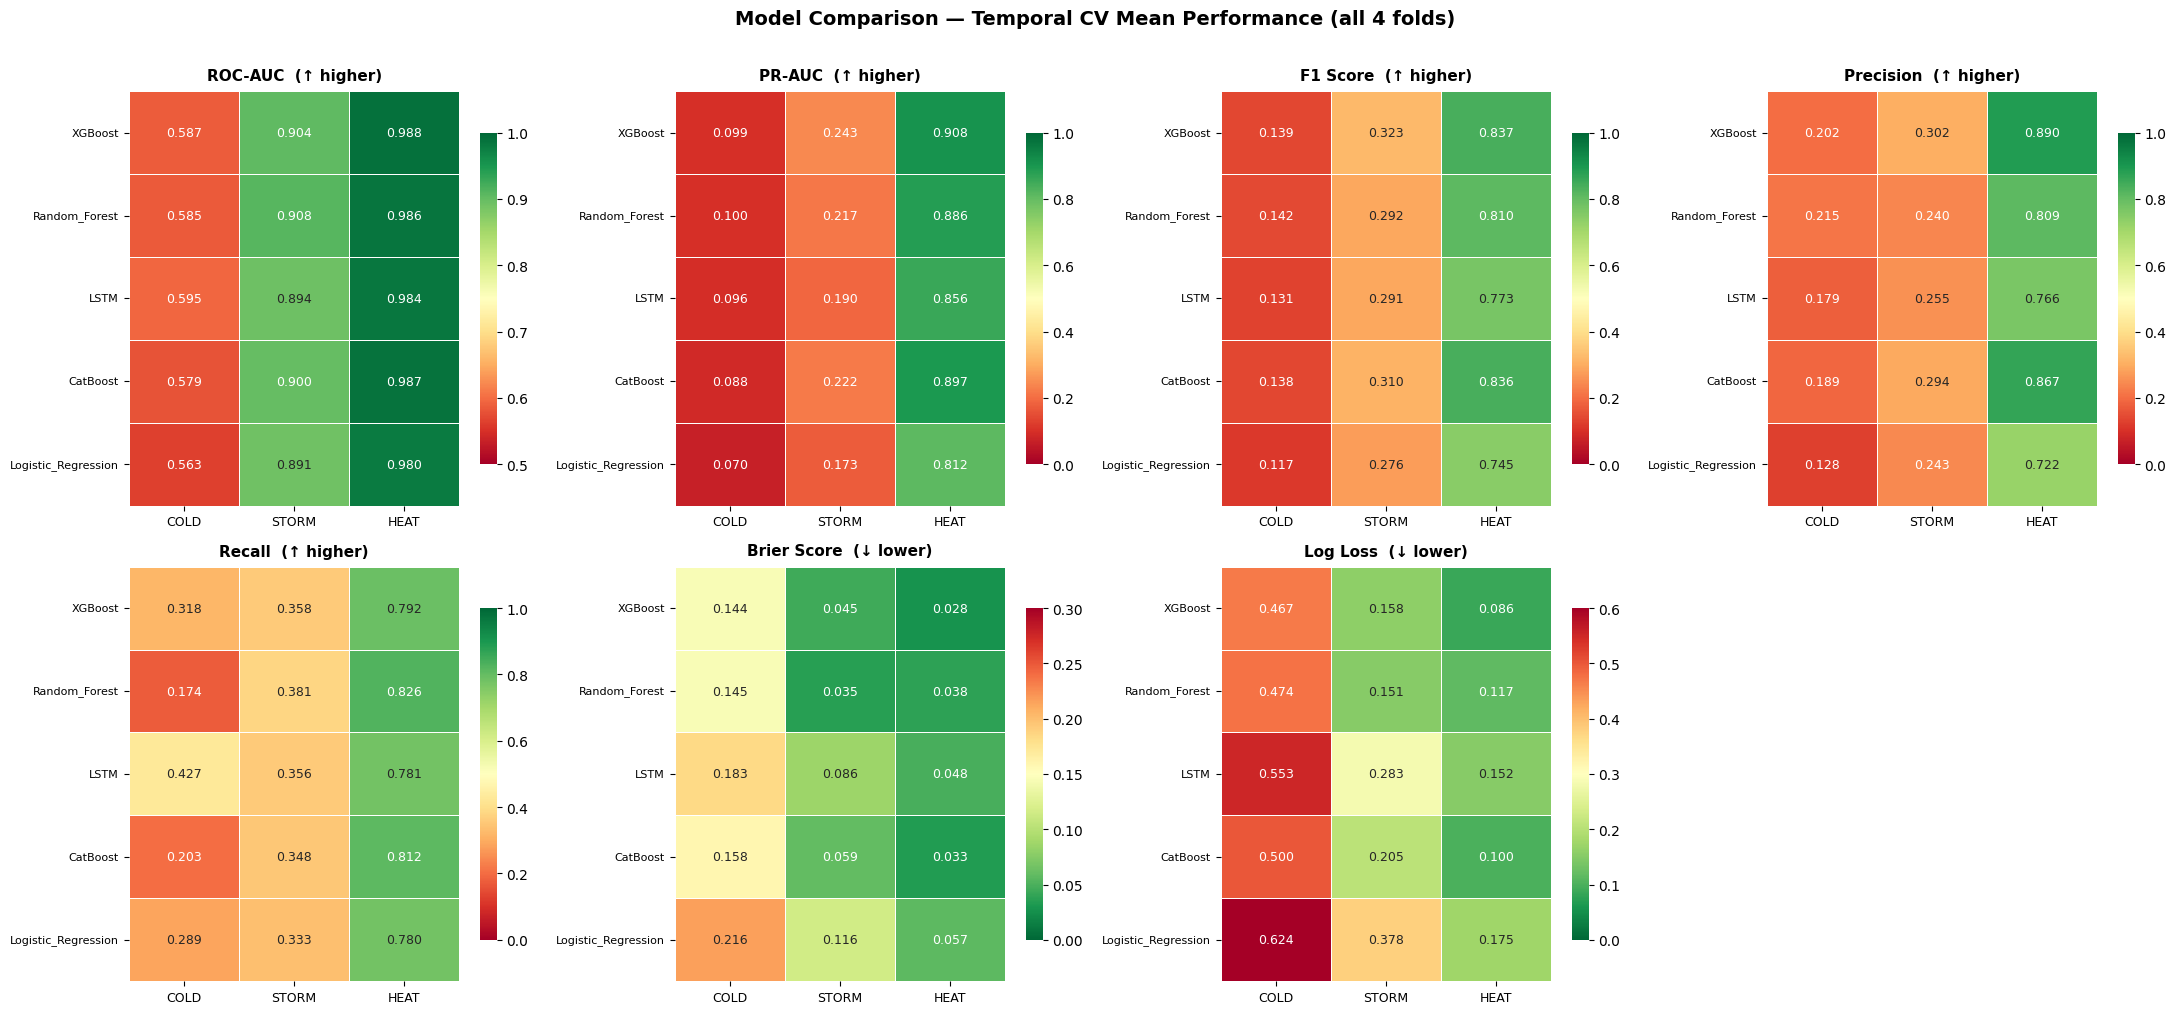


Heatmap saved as 'model_comparison_heatmaps.png'


In [15]:
# ============================================================
# COMPREHENSIVE METRICS HEATMAP
# ============================================================
# 7 subplots — one per metric — each a (models × targets) heatmap.
# Color direction is consistent: green = good (high AUC/F1/Precision/Recall,
# low Brier/LogLoss). Models sorted by mean ROC-AUC for readability.

MODEL_ORDER = (
    summary_df.groupby('model')['roc_auc_mean']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)
TARGETS    = ['COLD', 'STORM', 'HEAT']

METRIC_CONFIGS = [
    ('roc_auc',     'ROC-AUC',          'RdYlGn',   True,  0.5, 1.0),
    ('pr_auc',      'PR-AUC',           'RdYlGn',   True,  0.0, 1.0),
    ('f1',          'F1 Score',         'RdYlGn',   True,  0.0, 1.0),
    ('precision',   'Precision',        'RdYlGn',   True,  0.0, 1.0),
    ('recall',      'Recall',           'RdYlGn',   True,  0.0, 1.0),
    ('brier_score', 'Brier Score',      'RdYlGn_r', False, 0.0, 0.3),
    ('log_loss',    'Log Loss',         'RdYlGn_r', False, 0.0, 0.6),
]
# (metric_key, display_name, cmap, higher_is_better, vmin, vmax)

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for ax_idx, (metric, label, cmap, higher_is_better, vmin, vmax) in enumerate(METRIC_CONFIGS):
    ax = axes[ax_idx]

    col = f'{metric}_mean'
    pivot = (
        summary_df.pivot(index='model', columns='target', values=col)
        .reindex(index=MODEL_ORDER, columns=TARGETS)
    )

    sns.heatmap(
        pivot,
        annot=True, fmt='.3f',
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        ax=ax,
        linewidths=0.5, linecolor='white',
        cbar_kws={'shrink': 0.8},
        annot_kws={'size': 9}
    )

    direction = '↑ higher' if higher_is_better else '↓ lower'
    ax.set_title(f'{label}  ({direction})', fontsize=11, fontweight='bold', pad=8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=8)

# Hide the unused 8th subplot
axes[7].set_visible(False)

plt.suptitle(
    'Model Comparison — Temporal CV Mean Performance (all 4 folds)',
    fontsize=14, fontweight='bold', y=1.01
)
plt.tight_layout()
plt.savefig('model_comparison_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved as 'model_comparison_heatmaps.png'")
